# 1. Install and Import Dependencies

In [307]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [308]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [319]:
!pip install mss pyautogui

In [320]:
!pip install pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [321]:
!pip install gymnasium

In [322]:
# MSS for screen capture
from mss import mss
# Sending commands
import pyautogui
# Opencv for frame processing
import cv2
# Transformational framework
import numpy as np
# OCR for game over extraction
import pytesseract
from PIL import Image
# Visualize captured frames
from matplotlib import pyplot as plt
#Bring in time for pauses
import time
# Environment components
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [532]:
class CookieRun(Env):
  #Setup the environment action and observation shapes
  def __init__(self):
    super().__init__()
    self.observation_space = Box(low=0, high=255, shape=(1,90,160), dtype=np.uint8)
    self.action_space = Discrete(3)

    self.cap = mss()
    # game window
    self.game_location = {'top':0, 'left':0, 'width':1920, 'height':1080}
    # gameover window
    self.done_location = {'top':260, 'left':780, 'width':337, 'height':344}
    file = cv2.imread('./done.png')
    self.img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.img_hist = cv2.calcHist([self.img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.img_hist, self.img_hist, 0, 1, cv2.NORM_MINMAX)
    # reset x window
    self.x_location = {'top':192, 'left':1393, 'width':84, 'height':88}
    file = cv2.imread('./close.png')
    self.x_img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.x_img_hist = cv2.calcHist([self.x_img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.x_img_hist, self.x_img_hist, 0, 1, cv2.NORM_MINMAX)
    # score window
    self.score_location = {'top':160, 'left':760, 'width':350, 'height':64}
    #Sliding parameter
    self.sliding = False
    self.pre_reward = 0


  # What is called to do, something in the game
  def step(self, action):
    #Action key - 0 : Idle / 1 : jump / 2 : slide
    action_map = {
        0:'idle',
        1:'jump',
        2:'slide'
    }
    if action == 1:
        if self.sliding:
            pyautogui.mouseUp(x=1625, y=889)
            self.sliding = not(self.sliding)
        pyautogui.click(x=206, y=869)
    if action == 2:
        if self.sliding:
            pyautogui.mouseUp(x=1625, y=889)
        else:
            pyautogui.mouseDown(x=1625, y=889)
        self.sliding = not(self.sliding)

    #Checking whether game is done
    done, done_cap = self.get_done()
    #Get the next observation
    new_observation = self.get_observation()
    
    #set reward
    current_score = np.array(self.cap.grab(self.score_location))
    plt.imshow(current_score)
    str = pytesseract.image_to_string(current_score,config='digits -c tessedit_char_whitelist=0123456789 -c tessedit_char_blacklist=\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.\n')
    str = str[2:]
    if str:
        try:
            score = int(str)
            reward = (score - self.pre_reward)/1000
            self.pre_reward = score 
        except:
            reward = self.pre_reward/1000
    else:
        reward = self.pre_reward/1000
    
    info = {'arg1':1}

    return new_observation, reward, done, False, info

  # Restart the game
  def reset(self, seed=None):
    time.sleep(15)
    pyautogui.click(x=908, y=936)
    time.sleep(1)
    pyautogui.click(x=908, y=936)
    time.sleep(6)
    x_cap = np.array(self.cap.grab(self.x_location))
    x_cap = cv2.cvtColor(x_cap, cv2.COLOR_BGR2HSV)
    x_hist = cv2.calcHist([x_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(x_hist, x_hist, 0, 1, cv2.NORM_MINMAX)
    ret = cv2.compareHist(self.x_img_hist, x_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        pyautogui.click(x=1393, y=192)
        time.sleep(6)
    pyautogui.click(x=1534, y=900)
    time.sleep(1)
    pyautogui.click(x=1170, y=693)
    time.sleep(3)
    info = {'arg1':0}
    return self.get_observation(), info

  # Get the part of the obeservation of the game that we want
  def get_observation(self):
    # Get screen capture of game
    raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
    # Grayscale
    gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    # resize
    resize = cv2.resize(gray, (160,90))
    # Add channels first
    channel = np.reshape(resize, (1,90,160))
    return channel

  # Get the gameover state - Use opencv2 to compare image
  def get_done(self):
    done_cap = np.array(self.cap.grab(self.done_location))
    done_cap = cv2.cvtColor(done_cap, cv2.COLOR_BGR2HSV)
    done_hist = cv2.calcHist([done_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(done_hist, done_hist, 0, 1, cv2.NORM_MINMAX)
    done = False
    ret = cv2.compareHist(self.img_hist, done_hist, cv2.HISTCMP_CORREL)
    if ret > 0.9:
        done = True
        self.pre_reward = 0
    return done, done_cap

In [533]:
x, y = pyautogui.position()
print(x, y)

531 244


## 2.2 Test Environment

In [534]:
env= CookieRun()

False


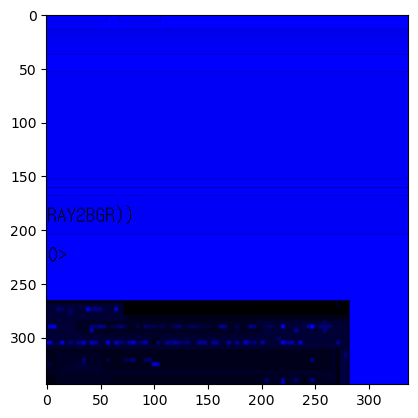

In [535]:
obs = env.get_observation()
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

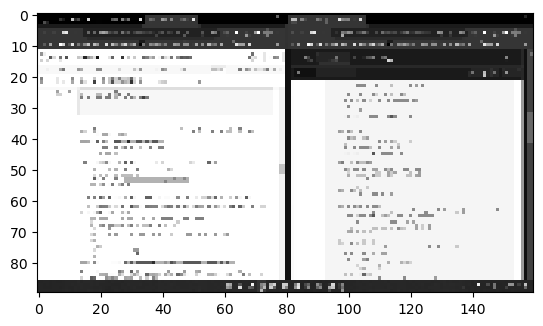

In [462]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

String is 


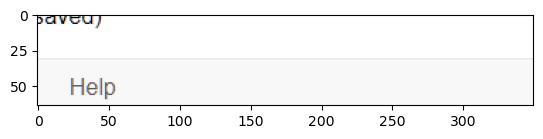

In [496]:
current_score = np.array(env.cap.grab({'top':160, 'left':760, 'width':350, 'height':64}))
plt.imshow(current_score)
str = pytesseract.image_to_string(current_score,config='digits -c tessedit_char_whitelist=0123456789')
str = str[2:]
print("String is " + str)

In [ ]:
env.reset()

# 3. Train the Model

## 3.1 Create Callback

In [512]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

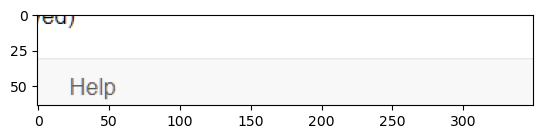

In [513]:
env_checker.check_env(env)

In [536]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [537]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [538]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build () and Train

In [539]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [540]:
env = CookieRun()

In [541]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 5.79e+06 |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 308      |
|    total_timesteps  | 684      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | 9.65e+06 |
|    exploration_rate | 0.877    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 573      |
|    total_timesteps  | 1295     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.67e+05 |
|    n_updates        | 73       |
----------------------------------
----------------------------------
| rollout/            |        

KeyboardInterrupt: 

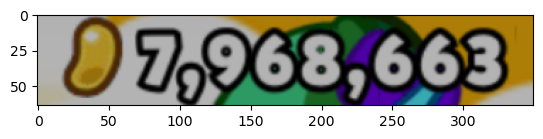

In [542]:
model.learn(total_timesteps=100000, callback=callback)

# 4. Test out Model